# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    #print(states.shape)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)
        print(actions)# all actions between -1 and 1
        break
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

[[ 0.90161828 -0.28813249]
 [ 1.         -0.47540189]]
Score (max over agents) from episode 1: 0.0
[[-0.23630638  0.15580549]
 [-1.         -0.30108238]]
Score (max over agents) from episode 2: 0.0
[[ 1.          0.67833423]
 [-0.91457291 -1.        ]]
Score (max over agents) from episode 3: 0.0
[[ 0.7542493   1.        ]
 [-0.18955721  1.        ]]
Score (max over agents) from episode 4: 0.0
[[-0.41979325 -1.        ]
 [ 0.64857207  0.18219429]]
Score (max over agents) from episode 5: 0.0


In [6]:
## Use one ddpg, and share the experiences, and train the agents
from multi_agent_ddpg import MultiAgent

n_agents = 2
multiagent = MultiAgent(n_agents, state_size, action_size, seed=2345)

In [7]:
from utils import plot_scores

We will now implement self play through Multi agent DDPG. The policy will be a mix of the actor and the critic of each of the agents

When finished, you can close the environment.

In [8]:
from collections import deque
import numpy as np
import torch
def multi_agent(n_episodes=500,  max_t=100000, eps_start=3.0, eps_end=0.01, eps_decay=0.999, attempt=None):
    """Deep DPG
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start: noise decay start
        eps_end: terminal noise decay
        eps_decay: decay rate per episode
        
    """
    scores_ = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start
    attain_max = False
    low_bound = 0.5
    for i_episode in range(1, n_episodes+1):           
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations
        scores = np.zeros(n_agents)  
        eps_ = eps
        for t in range(max_t):
            # let it go random for a while
            if i_episode < 10:
                action = np.random.randn(num_agents, action_size) # select an action (for each agent)
                action = np.clip(action, -1, 1)
                #print("random action {}:".format(action))
            else:
                action = multiagent.act(state, eps_ )
                #action_0 = multiagent.agents[0].act(state[0], 0)
                #action_1 = multiagent.agents[1].act(state[1], 0)
                #print("action 0: {}".format(action_0))
                #print("action 1: {}".format(action_1))
            #print("action fed to the environment: {}".format(action))
            env_info = env.step(action, eps)[brain_name]        # send the actionS to the environment and brain
            next_state = env_info.vector_observations   # get the next states
            reward = env_info.rewards                   # get the rewards
            dones = env_info.local_done   # get the done status for both agents
            multiagent.step(state, action, reward, next_state, dones) # Add to memory, and if enough steps, learn
            state = next_state
            scores += env_info.rewards
            eps_ = 0.99 * eps_
            if np.any(dones):                                  # exit loop if episode finished
                break
           
        scores_.append(scores)
        scores_window.append(scores)       # save most recent score
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        scores_window_max = np.max(scores_window, axis=1)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window_max)), end="")
        if i_episode % 250 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window_max)))
            # Add plots every 250 episodes
            plot_scores(np.max(scores_, axis=1), attempt, i_episode)
        if np.mean(scores_window_max)>=low_bound and attain_max==False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window_max)))
            for i, agent in enumerate(multiagent.agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic{}.pth'.format(i))
                attain_max = True
                low_bound = np.mean(scores_window_max)
                break
        elif np.mean(scores_window_max) > low_bound:
            print('\nMaxium average achieved after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window_max)))
            for i, agent in enumerate(multiagent.agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic{}.pth'.format(i))
                attain_max = True
                low_bound = np.mean(scores_window_max)
            low_bound = np.mean(scores_window_max)
    return scores_






Episode 250	Average Score: 0.00


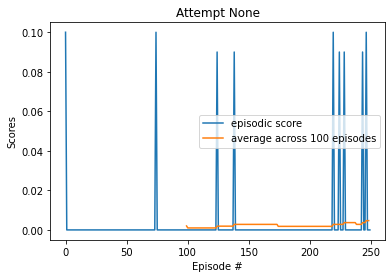

Episode 500	Average Score: 0.03


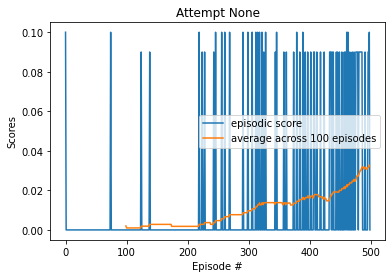

Episode 750	Average Score: 0.03


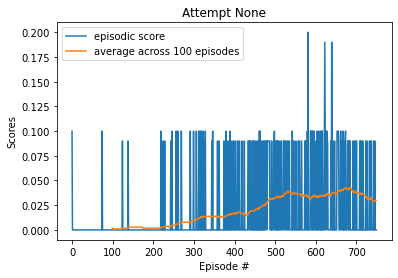

Episode 1000	Average Score: 0.03


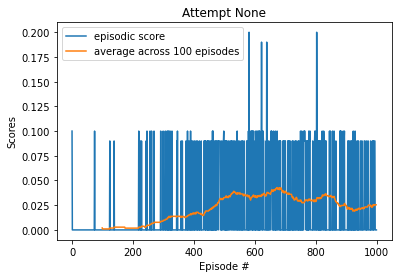

Episode 1250	Average Score: 0.05


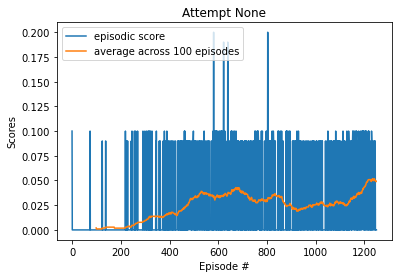

Episode 1500	Average Score: 0.13


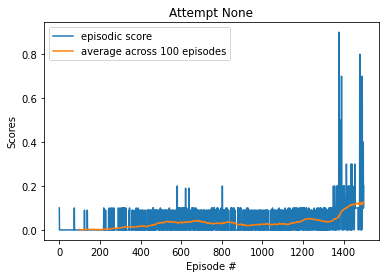

Episode 1750	Average Score: 0.15


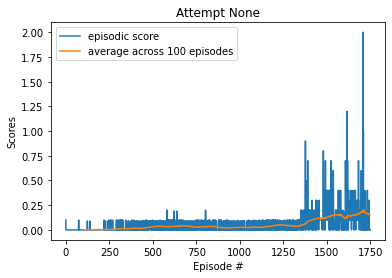

Episode 2000	Average Score: 0.13


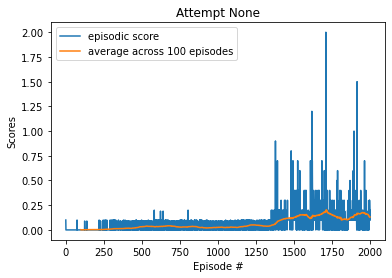

Episode 2250	Average Score: 0.12


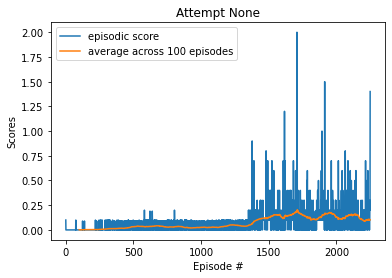

Episode 2500	Average Score: 0.18


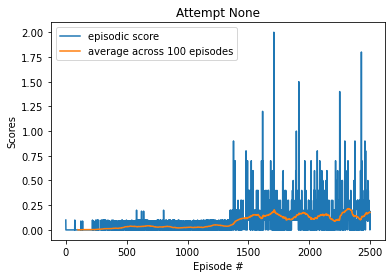

Episode 2750	Average Score: 0.25


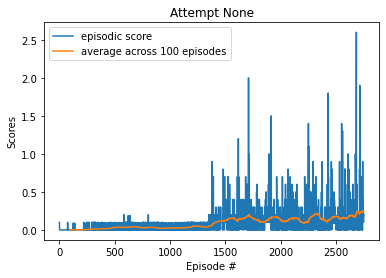

Episode 3000	Average Score: 0.43


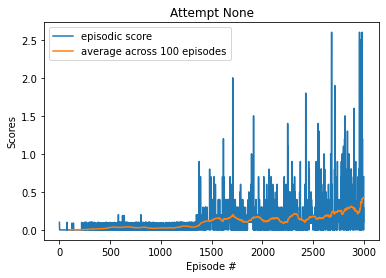

Episode 3043	Average Score: 0.51
Environment solved in 2943 episodes!	Average Score: 0.51
Episode 3142	Average Score: 0.52
Maxium average achieved after 3142 episodes!	Average Score: 0.52
Episode 3143	Average Score: 0.53
Maxium average achieved after 3143 episodes!	Average Score: 0.53
Episode 3144	Average Score: 0.53
Maxium average achieved after 3144 episodes!	Average Score: 0.53
Episode 3146	Average Score: 0.53
Maxium average achieved after 3146 episodes!	Average Score: 0.53
Episode 3149	Average Score: 0.53
Maxium average achieved after 3149 episodes!	Average Score: 0.53
Episode 3154	Average Score: 0.54
Maxium average achieved after 3154 episodes!	Average Score: 0.54
Episode 3155	Average Score: 0.54
Maxium average achieved after 3155 episodes!	Average Score: 0.54
Episode 3156	Average Score: 0.54
Maxium average achieved after 3156 episodes!	Average Score: 0.54
Episode 3157	Average Score: 0.54
Maxium average achieved after 3157 episodes!	Average Score: 0.54
Episode 3158	Average Score: 

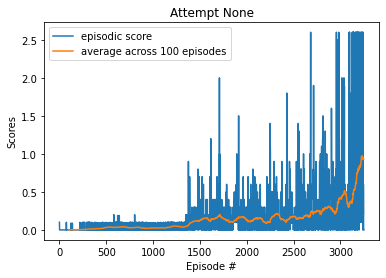

Episode 3500	Average Score: 0.25


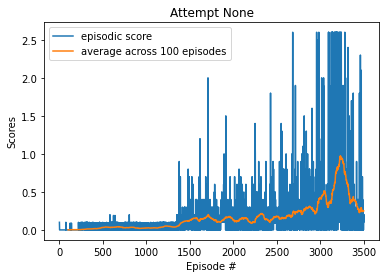

Episode 3750	Average Score: 0.47


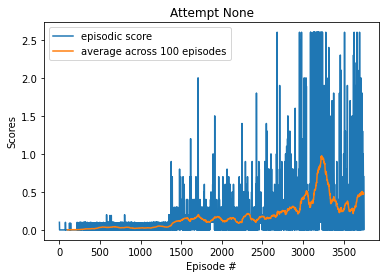

Episode 4000	Average Score: 0.48


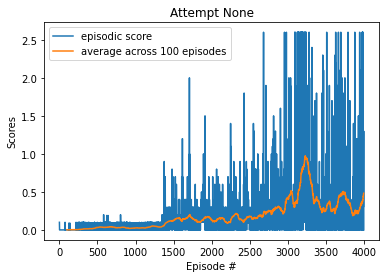

Episode 4250	Average Score: 0.47


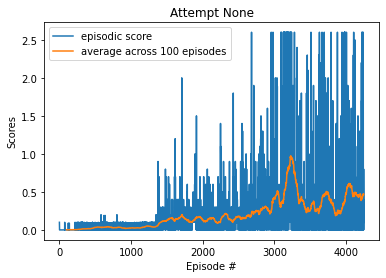

Episode 4500	Average Score: 0.50


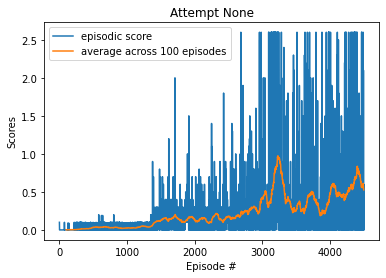

Episode 4750	Average Score: 0.53


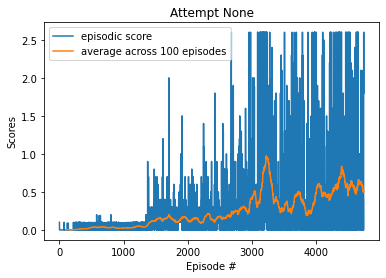

Episode 5000	Average Score: 0.57


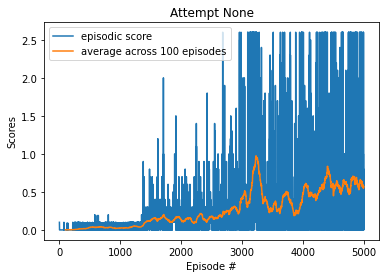

Episode 5217	Average Score: 0.98
Maxium average achieved after 5217 episodes!	Average Score: 0.98
Episode 5250	Average Score: 0.78


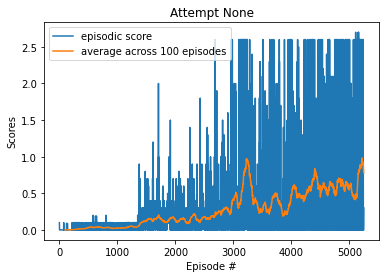

Episode 5500	Average Score: 0.69


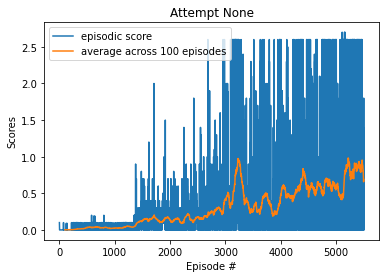

Episode 5750	Average Score: 0.51


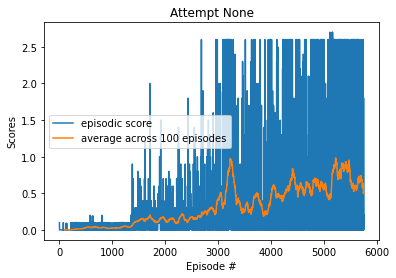

Episode 6000	Average Score: 0.62


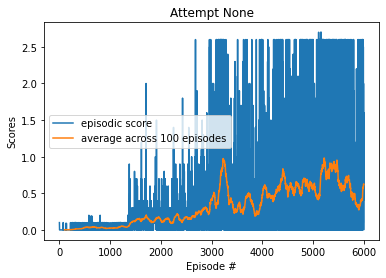

Episode 6250	Average Score: 0.78


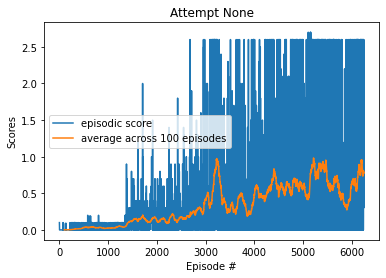

Episode 6421	Average Score: 0.98
Maxium average achieved after 6421 episodes!	Average Score: 0.98
Episode 6422	Average Score: 1.00
Maxium average achieved after 6422 episodes!	Average Score: 1.00
Episode 6428	Average Score: 1.01
Maxium average achieved after 6428 episodes!	Average Score: 1.01
Episode 6429	Average Score: 1.04
Maxium average achieved after 6429 episodes!	Average Score: 1.04
Episode 6430	Average Score: 1.06
Maxium average achieved after 6430 episodes!	Average Score: 1.06
Episode 6437	Average Score: 1.07
Maxium average achieved after 6437 episodes!	Average Score: 1.07
Episode 6438	Average Score: 1.08
Maxium average achieved after 6438 episodes!	Average Score: 1.08
Episode 6462	Average Score: 1.08
Maxium average achieved after 6462 episodes!	Average Score: 1.08
Episode 6465	Average Score: 1.09
Maxium average achieved after 6465 episodes!	Average Score: 1.09
Episode 6500	Average Score: 0.98


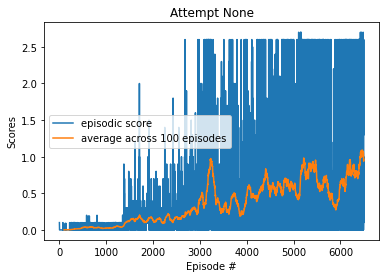

Episode 6557	Average Score: 1.10
Maxium average achieved after 6557 episodes!	Average Score: 1.10
Episode 6559	Average Score: 1.10
Maxium average achieved after 6559 episodes!	Average Score: 1.10
Episode 6560	Average Score: 1.13
Maxium average achieved after 6560 episodes!	Average Score: 1.13
Episode 6566	Average Score: 1.15
Maxium average achieved after 6566 episodes!	Average Score: 1.15
Episode 6567	Average Score: 1.17
Maxium average achieved after 6567 episodes!	Average Score: 1.17
Episode 6568	Average Score: 1.19
Maxium average achieved after 6568 episodes!	Average Score: 1.19
Episode 6570	Average Score: 1.22
Maxium average achieved after 6570 episodes!	Average Score: 1.22
Episode 6574	Average Score: 1.22
Maxium average achieved after 6574 episodes!	Average Score: 1.22
Episode 6575	Average Score: 1.24
Maxium average achieved after 6575 episodes!	Average Score: 1.24
Episode 6576	Average Score: 1.27
Maxium average achieved after 6576 episodes!	Average Score: 1.27
Episode 6577	Average

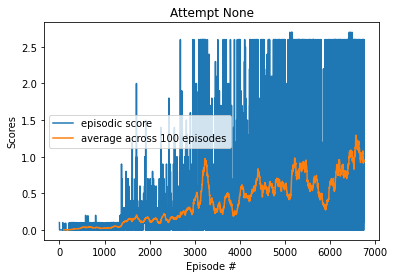

Episode 7000	Average Score: 0.74


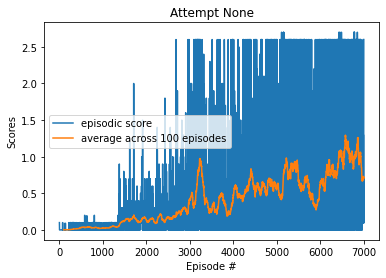

Episode 7072	Average Score: 0.82

In [ ]:
scores = multi_agent(n_episodes=10000)

In [ ]:
dones = torch.tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 2.]],

        [[0., 0.]]])
print(dones.shape)

In [ ]:
dones[:,:,1] == False

In [ ]:
np.dstack(states).shape

In [ ]:
t = torch.tensor([[[1, 2],
                       [3, 4]],
                      [[5, 6],
                       [7, 8]]])
t.shape